In [112]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [113]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [114]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [115]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [116]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [117]:
# View all of the classes that automap found
for table_name, mapped_class in Base.classes.items():
    print(f"Table Name: {table_name}, Class Name: {mapped_class.__name__}")

Table Name: measurement, Class Name: measurement
Table Name: station, Class Name: station


In [118]:
#display the data tables so I can see what I'm working with
conn = engine.connect()
m_df = pd.read_sql('select * from measurement', conn)
m_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [119]:
s_df = pd.read_sql('select * from station', conn)
s_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [120]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [121]:
# Create our session (link) from Python to the DB
session = Session(engine)
measurement_results = session.query(Measurement).all()
station_results = session.query(Station).all()

# Exploratory Precipitation Analysis

In [122]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
print(f'Most recent date: {most_recent_date}')

Most recent date: 2017-08-23


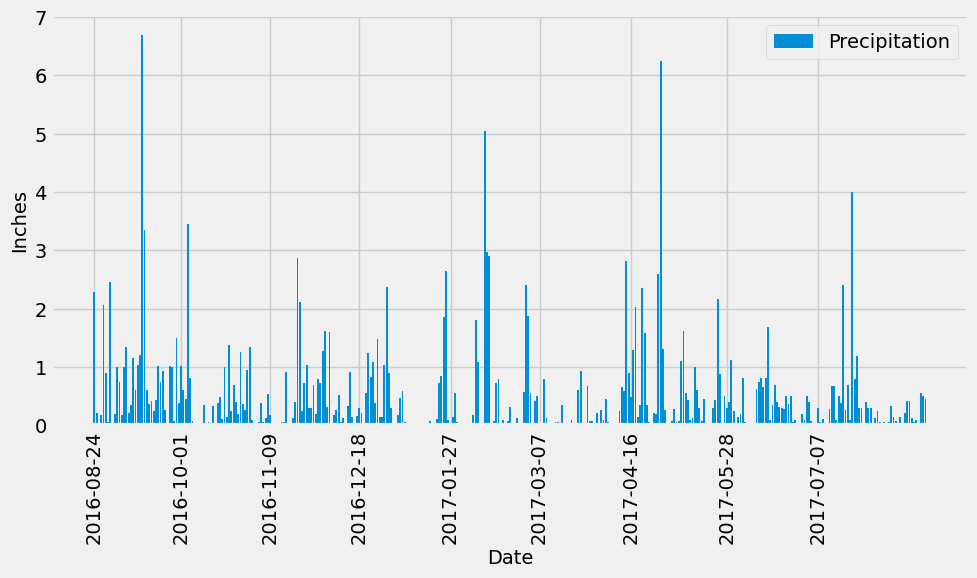

In [124]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Convert most_recent_date to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
date_ticks = precipitation_df['Date']
plt.xticks(precipitation_df['Date'].iloc[::len(precipitation_df) // 9], rotation=90)
plt.tight_layout()
plt.show()

In [125]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [126]:
# Design a query to calculate the total number of stations in the dataset
total_stations = engine.execute("select count(distinct station) from station").scalar()

# Display the total number of stations
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [127]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
sql_query = """
    SELECT station, COUNT(station) AS station_count
    FROM measurement
    GROUP BY station
    ORDER BY station_count DESC
"""
results = engine.execute(sql_query).fetchall()

for station, count in results:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [128]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_query = """
    SELECT station
    FROM measurement
    GROUP BY station
    ORDER BY COUNT(station) DESC
    LIMIT 1
"""

most_active_station_result = engine.execute(most_active_station_query).fetchone()

if most_active_station_result is not None:
    most_active_station_id = most_active_station_result[0]

    temperature_stats_query = f"""
        SELECT MIN(tobs) AS min_temp, MAX(tobs) AS max_temp, AVG(tobs) AS avg_temp
        FROM measurement
        WHERE station = '{most_active_station_id}'
    """

    temperature_stats_result = engine.execute(temperature_stats_query).fetchone()

    lowest_temp, highest_temp, avg_temp = temperature_stats_result

    print(f"Most Active Station ID: {most_active_station_id}")
    print(f"Lowest Temperature: {lowest_temp}°F")
    print(f"Highest Temperature: {highest_temp}°F")
    print(f"Average Temperature: {avg_temp}°F")
else:
    print("No data found for the most active station.")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


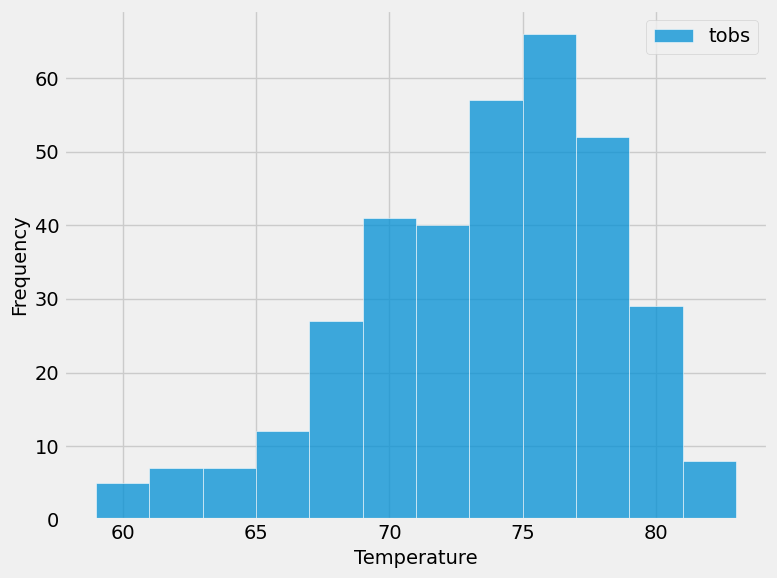

In [135]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='tobs', alpha=0.75, edgecolor='white')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Close Session

In [136]:
# Close Session
session.close()